In [9]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import joblib

In [11]:

# Set memory management env variable
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cpu


In [13]:
# === LOAD METADATA AND FILTER B0005 DISCHARGE CYCLES ===
def load_discharge_files(metadata_path, csv_folder):
    metadata = pd.read_csv(metadata_path)
    # Filter for (B0005) battery discharge cycles
    discharge_files = metadata[(metadata['type'] == 'discharge') & (metadata['battery_id'] == 'B0005')]['filename'].tolist()
    # Append '_with_soc' to each filename
    discharge_files = [f.replace('.csv', '_with_soc.csv') for f in discharge_files]
    print(f"Found {len(discharge_files)} discharge cycles for B0055: {discharge_files[:5]}...")
    return discharge_files

In [15]:
# === LOAD AND PREPROCESS DATA FOR PREDICTION ===
def load_data_for_prediction(discharge_files, csv_folder, sequence_length=64, scaler_path="scaler_x.pkl"):
    all_data = []
    for file in discharge_files:
        file_path = os.path.join(csv_folder, file)
        if os.path.exists(file_path):
            df = pd.read_csv(file_path, usecols=[0, 1, 2, 3])  # Voltage, Current, Time, SOC
            all_data.append(df)
        else:
            print(f"⚠️ File not found: {file_path}")

    if not all_data:
        print("⚠️ No discharge data found. Exiting.")
        exit()

    df = pd.concat(all_data, ignore_index=True)
    
    # Load the pre-trained scaler
    scaler_x = joblib.load(scaler_path)
    df.iloc[:, [0, 1, 2]] = scaler_x.transform(df.iloc[:, [0, 1, 2]])

    data = df.iloc[:, [0, 1, 2]].values  # Features (Voltage, Current, Time)
    labels = df.iloc[:, 3].values  # SOC target (ground truth for evaluation)

    X, y = [], []
    for i in range(sequence_length, len(data)):
        X.append(data[i - sequence_length:i])
        y.append(labels[i])

    X, y = np.array(X), np.array(y)
    print(f"Discharge dataset shape: X shape: {X.shape}, y shape: {y.shape}")

    return X, y

In [17]:
# === LSTM-ATTENTION MODEL ===
class LSTM_Attention_SOC(nn.Module):
    def __init__(self, input_size=3, hidden_size=32, num_layers=2, num_heads=4, dropout=0.2):
        super(LSTM_Attention_SOC, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, 
                            num_layers=num_layers, batch_first=True, dropout=dropout)
        self.attention = nn.MultiheadAttention(embed_dim=hidden_size, 
                                               num_heads=num_heads, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        lstm_out, _ = self.lstm(x, (h0, c0))
        attn_out, _ = self.attention(lstm_out, lstm_out, lstm_out)
        out = self.fc(attn_out[:, -1, :])
        return out

In [19]:
# === TRANSFORMER MODEL ===
class TransformerSOC(nn.Module):
    def __init__(self, input_size=3, d_model=32, nhead=4, num_layers=2, dropout=0.2):
        super(TransformerSOC, self).__init__()
        self.input_projection = nn.Linear(input_size, d_model)
        self.pos_encoder = nn.Parameter(torch.zeros(1, 64, d_model))
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.input_projection(x)
        x = x + self.pos_encoder[:, :x.size(1), :]
        x = self.transformer_encoder(x)
        x = self.fc(x[:, -1, :])
        return x

In [21]:
# === LOAD AND PREDICT WITH LSTM-ATTENTION ===
def load_lstm_attention_predictions(X_data, model_path="lstm_attention_soc_v2.pkl", batch_size=16):
    model = LSTM_Attention_SOC(input_size=3, hidden_size=32, num_layers=2, num_heads=4).to(device)
    model.load_state_dict(torch.load(model_path, weights_only=True))
    model.eval()

    X_tensor = torch.tensor(X_data, dtype=torch.float32)
    dataset = TensorDataset(X_tensor, torch.zeros(X_tensor.shape[0], 1))
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    y_pred_list = []
    with torch.no_grad():
        for X_batch, _ in dataloader:
            X_batch = X_batch.to(device)
            y_pred = model(X_batch)
            y_pred_list.append(y_pred.cpu().numpy())
    
    y_pred = np.concatenate(y_pred_list, axis=0)
    print("✅ LSTM-Attention predictions made")
    return y_pred


In [23]:
# === LOAD AND PREDICT WITH TRANSFORMER ===
def load_transformer_predictions(X_data, model_path="transformer_soc_v2.pkl", batch_size=16):
    model = TransformerSOC(input_size=3, d_model=32, nhead=4, num_layers=2).to(device)
    model.load_state_dict(torch.load(model_path, weights_only=True))
    model.eval()

    X_tensor = torch.tensor(X_data, dtype=torch.float32)
    dataset = TensorDataset(X_tensor, torch.zeros(X_tensor.shape[0], 1))
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    y_pred_list = []
    with torch.no_grad():
        for X_batch, _ in dataloader:
            X_batch = X_batch.to(device)
            y_pred = model(X_batch)
            y_pred_list.append(y_pred.cpu().numpy())
    
    y_pred = np.concatenate(y_pred_list, axis=0)
    print("✅ Transformer predictions made")
    return y_pred


Found 168 discharge cycles for B0055: ['05122_with_soc.csv', '05124_with_soc.csv', '05126_with_soc.csv', '05128_with_soc.csv', '05130_with_soc.csv']...
Discharge dataset shape: X shape: (50221, 64, 3), y shape: (50221,)
✅ LSTM-Attention predictions made
✅ Transformer predictions made

Ensemble Weights - LSTM-Attention: 0.6781, Transformer: 0.3219

Ensemble Prediction Metrics (Discharge Cycles) - MSE: 0.002232, MAE: 0.010652, RMSE: 0.047240
📊 Prediction plot saved to ensemble_predictions_discharge_metadata.png
📊 Predicted vs True plot saved to predicted_vs_true_discharge_metadata.png


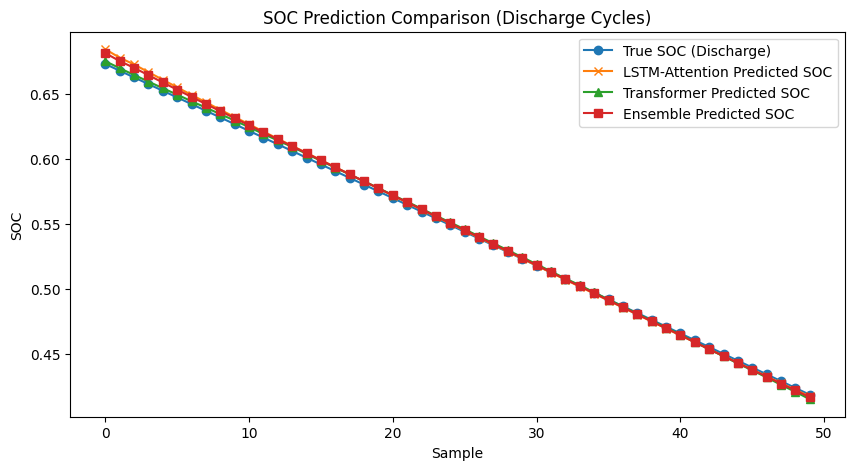

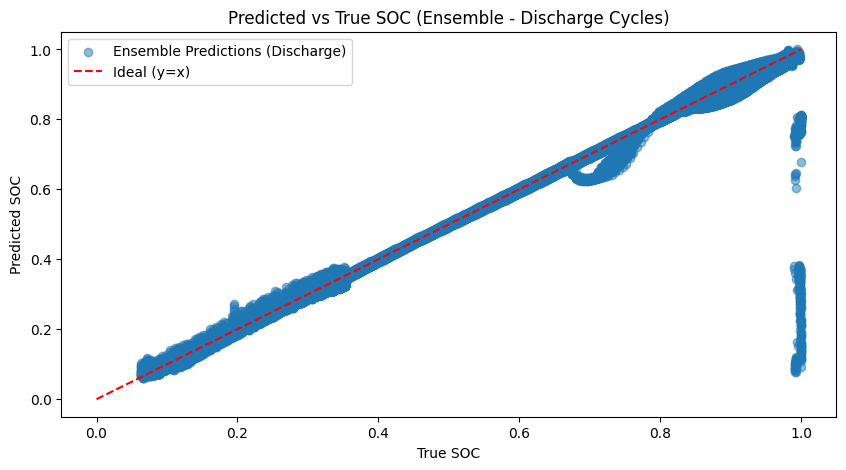

In [25]:
# === MAIN EXECUTION ===
if __name__ == "__main__":
    metadata_path = r"D:\NASA_Battery_Dataset\cleaned_dataset\metadata.csv"
    csv_folder = r"C:\Users\AK\Desktop\Model_comparison\processed_csv_files_reduced"

    # Load metadata and filter discharge cycles
    discharge_files = load_discharge_files(metadata_path, csv_folder)

    if not discharge_files:
        print("⚠️ No discharge cycles found in metadata. Please check the metadata file.")
        exit()

    # Load the data for discharge cycles
    X_discharge, y_discharge = load_data_for_prediction(discharge_files, csv_folder)

    if X_discharge.shape[0] == 0:
        print("⚠️ No discharge data found after preprocessing. Please check the data or preprocessing steps.")
        exit()

    # Make predictions using pre-trained models
    lstm_y_pred = load_lstm_attention_predictions(X_discharge)
    transformer_y_pred = load_transformer_predictions(X_discharge)

    # Weighted ensemble (using best test losses from prior training)
    lstm_best_test_loss = 0.000047  # From your training results
    transformer_best_test_loss = 0.000099  # From your training results
    total_loss = lstm_best_test_loss + transformer_best_test_loss
    lstm_weight = (1 / lstm_best_test_loss) / ((1 / lstm_best_test_loss) + (1 / transformer_best_test_loss))
    transformer_weight = (1 / transformer_best_test_loss) / ((1 / lstm_best_test_loss) + (1 / transformer_best_test_loss))
    print(f"\nEnsemble Weights - LSTM-Attention: {lstm_weight:.4f}, Transformer: {transformer_weight:.4f}")

    ensemble_y_pred = lstm_weight * lstm_y_pred + transformer_weight * transformer_y_pred

    # Evaluate metrics
    y_discharge_np = y_discharge.reshape(-1, 1)
    mse_ensemble = np.mean((ensemble_y_pred - y_discharge_np) ** 2)
    mae_ensemble = np.mean(np.abs(ensemble_y_pred - y_discharge_np))
    rmse_ensemble = np.sqrt(mse_ensemble)

    print(f"\nEnsemble Prediction Metrics (Discharge Cycles) - MSE: {mse_ensemble:.6f}, MAE: {mae_ensemble:.6f}, RMSE: {rmse_ensemble:.6f}")

    # Plot predictions (first 50 samples)
    plt.figure(figsize=(10, 5))
    plt.plot(y_discharge_np[:50], label='True SOC (Discharge)', marker='o')
    plt.plot(lstm_y_pred[:50], label='LSTM-Attention Predicted SOC', marker='x')
    plt.plot(transformer_y_pred[:50], label='Transformer Predicted SOC', marker='^')
    plt.plot(ensemble_y_pred[:50], label='Ensemble Predicted SOC', marker='s')
    plt.title('SOC Prediction Comparison (Discharge Cycles)')
    plt.xlabel('Sample')
    plt.ylabel('SOC')
    plt.legend()
    plt.savefig('ensemble_predictions_discharge_metadata.png')
    print("📊 Prediction plot saved to ensemble_predictions_discharge_metadata.png")

    # Plot predicted vs true
    plt.figure(figsize=(10, 5))
    plt.scatter(y_discharge_np, ensemble_y_pred, alpha=0.5, label='Ensemble Predictions (Discharge)')
    plt.plot([0, 1], [0, 1], 'r--', label='Ideal (y=x)')
    plt.xlabel('True SOC')
    plt.ylabel('Predicted SOC')
    plt.title('Predicted vs True SOC (Ensemble - Discharge Cycles)')
    plt.legend()
    plt.savefig('predicted_vs_true_discharge_metadata.png')
    print("📊 Predicted vs True plot saved to predicted_vs_true_discharge_metadata.png")

    if device.type == "cuda":
        torch.cuda.empty_cache()